In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import uproot
import awkward as ak
import ROOT
from scipy.stats import ks_2samp

Welcome to JupyROOT 6.28/04


This paper gives the technical details about this reweighting method: [arXiv:2007.11586 [hep-ph]](https://arxiv.org/abs/2007.11586). 

This is follow-up work related to the GitHub repository: [GitHub Repository](https://github.com/dinupa1/bm-function/blob/NeuralPositiveReweighting/NeuralPositiveReweighting.ipynb)


The goal is to learn new event weights in Monte Carlo (MC) events through the neural network training process. The background events (may) contain negative event weights. The loss function to be minimized is:


\begin{equation}
\label{eq:loss}
\mathcal{L}[g] = -\sum_{i= 1}^N w_i \log g(x_i) -\sum_{i=1}^N \log\big(1-g(x_i)\big),
\end{equation}

Where $g(x)$ is parameterized as a neural network with an output range of $[0,1]$. From the loss function minimum, one could obtain the reweighted function:

\begin{equation}
\label{eq:learned_w_given_x}
f(x) = \frac{g(x)}{1-g(x)}  
\end{equation}

The weights for the MC events will be calculated using the function.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, input_dim: int = 1, output_dim: int = 1, hidden_dim: int = 128):
        super(Net, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [3]:
batch_size = 2000

tree0 = uproot.open("data/mc_lh2_train_reco.root:result_mc")
events0 = tree0.arrays(['mass', 'pT', 'xF', 'D1'])

tree1 = uproot.open("data/unmix_lh2.root:result")
events1 = tree1.arrays(['mass', 'pT', 'xF', 'D1', 'weight'])

n_LH2_events = len(events1)
n_LH2_events = len(events1)

events0 = events0[:n_LH2_events]
events1 = events1[:n_LH2_events]
print("Number of events:", n_LH2_events)

# Extract feature matrices X0 and X1
X0 = [(mass, pT, xF, D1) for mass, pT, xF, D1 in zip(*[events0[var] for var in ['mass', 'pT', 'xF', 'D1']])]
X1 = [(mass, pT, xF, D1) for mass, pT, xF, D1 in zip(*[events1[var] for var in ['mass', 'pT', 'xF', 'D1']])]


Number of events: 688287


In [4]:
# Extract weights
weight0 = np.ones(n_LH2_events)
weight1 = events1['weight'].to_numpy()

Y0 = np.zeros(n_LH2_events)
Y1 = np.ones(n_LH2_events)
weight1 = events1.weight.to_numpy()


In [5]:
X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1)).reshape(-1, 1)
weight = np.concatenate((weight0, weight1)).reshape(-1, 1)

X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()
W_tensor = torch.from_numpy(weight).float()

X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X_tensor, Y_tensor, W_tensor, test_size=0.4, shuffle=True)
train_dataset = TensorDataset(X_train, Y_train, W_train)
test_dataset = TensorDataset(X_test, Y_test, W_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Custom loss function
class NetLoss(nn.Module):
    def __init__(self):
        super(NetLoss, self).__init__()

    def forward(self, outputs, targets, weights):
        criterion = nn.BCELoss(reduction="none")
        loss = criterion(outputs, targets)
        weighted_loss = loss* weights
        return weighted_loss.mean()


In [7]:
model = Net(input_dim = 4)
criterion = NetLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model = model.to(device=device)

print("using device : {}".format(device))
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print('total trainable params: {}'.format(total_trainable_params))

using device : cpu
Net(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
total trainable params: 33793


In [8]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for batch_inputs, batch_labels, batch_weights in dataloader:
            batch_inputs, batch_labels, batch_weights = (
                batch_inputs.to(device),
                batch_labels.to(device),
                batch_weights.to(device)
            )
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels, batch_weights)
            running_loss += loss.item() * batch_inputs.size(0)
    return running_loss / len(dataloader.dataset)

def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience):
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    train_losses = []  
    valid_losses = []  

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for batch_inputs, batch_labels, batch_weights in train_loader:
            batch_inputs, batch_labels, batch_weights = (
                batch_inputs.to(device),
                batch_labels.to(device),
                batch_weights.to(device)
            )

            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels, batch_weights)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation
        validation_loss = evaluate_model(model, test_loader, criterion, device)

        train_losses.append(epoch_loss)
        valid_losses.append(validation_loss)

        print("Epoch {}: Train Loss = {:.4f}, Test Loss = {:.4f}".format(epoch + 1, epoch_loss, validation_loss))

        # Check for early stopping
        if validation_loss < best_loss:
            best_loss = validation_loss
            best_model_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping at epoch {}".format(epoch))
            break

    return best_model_weights, train_losses, valid_losses


In [9]:
def reweight_fn(model, X_val):
    model = model.to(torch.device("cpu"))

    model.eval()
    with torch.no_grad():
        preds = model(torch.Tensor(X_val)).detach().numpy().ravel()
        weights = preds / (1.0 - preds)
    return weights

In [10]:
epochs = 200
early_stopping_patience =20

# Compile the train function
opt_train = torch.compile(train_model, mode="max-autotune")
best_model_weights, train_losses, valid_losses = opt_train(model, train_loader, test_loader, criterion, optimizer, device, epochs, early_stopping_patience)


Epoch 1: Train Loss = 0.6919, Test Loss = 0.6734
Epoch 2: Train Loss = 0.6747, Test Loss = 0.6705
Epoch 3: Train Loss = 0.6723, Test Loss = 0.6700
Epoch 4: Train Loss = 0.6701, Test Loss = 0.6677
Epoch 5: Train Loss = 0.6688, Test Loss = 0.6660
Epoch 6: Train Loss = 0.6681, Test Loss = 0.6658
Epoch 7: Train Loss = 0.6666, Test Loss = 0.6659
Epoch 8: Train Loss = 0.6663, Test Loss = 0.6684
Epoch 9: Train Loss = 0.6658, Test Loss = 0.6659
Epoch 10: Train Loss = 0.6651, Test Loss = 0.6719
Epoch 11: Train Loss = 0.6647, Test Loss = 0.6642
Epoch 12: Train Loss = 0.6646, Test Loss = 0.6627
Epoch 13: Train Loss = 0.6639, Test Loss = 0.6662
Epoch 14: Train Loss = 0.6641, Test Loss = 0.6624
Epoch 15: Train Loss = 0.6638, Test Loss = 0.6618
Epoch 16: Train Loss = 0.6634, Test Loss = 0.6624
Epoch 17: Train Loss = 0.6627, Test Loss = 0.6615
Epoch 18: Train Loss = 0.6628, Test Loss = 0.6614
Epoch 19: Train Loss = 0.6626, Test Loss = 0.6608
Epoch 20: Train Loss = 0.6623, Test Loss = 0.6619
Epoch 21:

Configured with: --prefix=/Users/forhadhossain/Downloads/Xcode.app/Contents/Developer/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX13.1.sdk/usr/include/c++/4.2.1


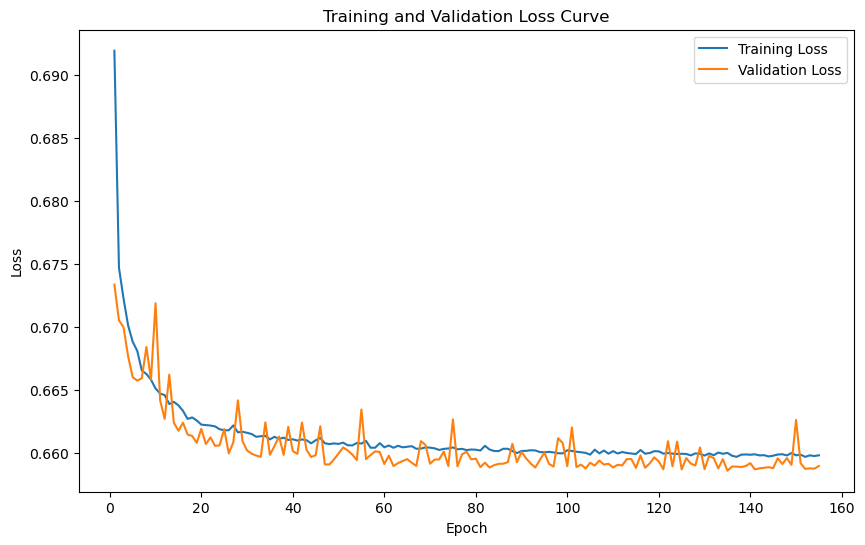

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')

plt.title('Training and Validation Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Load the best model weights
model.load_state_dict(best_model_weights)

X0 = np.array(X0)
X1 = np.array(X1)
weight0 = np.array(weight0)
weight1 = np.array(weight1)

weights = reweight_fn(model, torch.Tensor(X0))

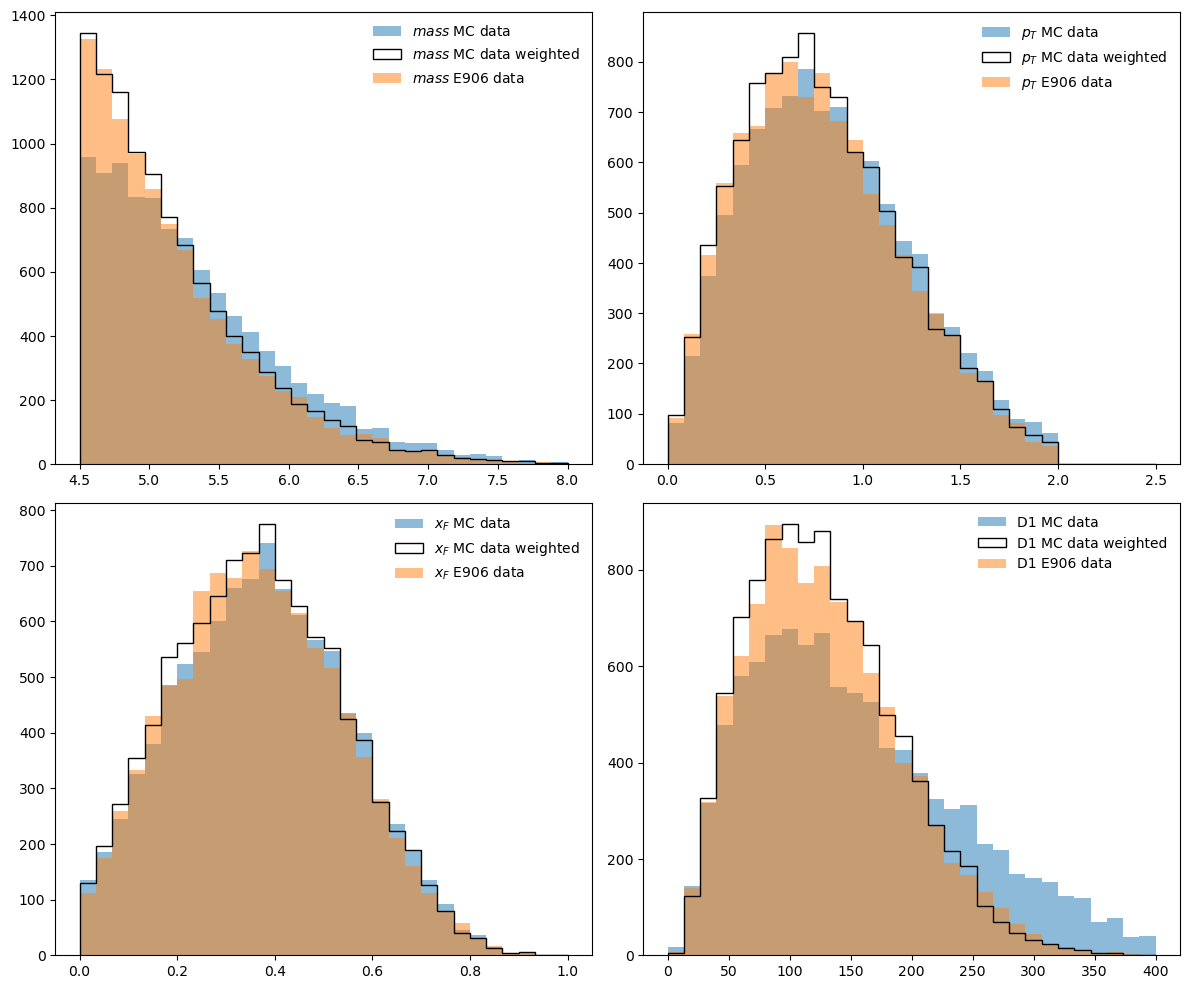

In [13]:
import numpy as np
import matplotlib.pyplot as plt
X0_subset = X0[:10000, :]
weights_subset = weights[:10000]
X1_subset = X1[:10000, :]
weight1_subset = weight1[:10000]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

#(mass)
bins_mass = np.linspace(4.5, 8.0, 31)
axs[0, 0].hist(X0_subset[:, 0], bins=bins_mass, alpha=0.5, label=r'$mass$ MC data')
axs[0, 0].hist(X0_subset[:, 0], bins=bins_mass, label=r'$mass$ MC data weighted', weights=weights_subset, histtype='step', color='k')
axs[0, 0].hist(X1_subset[:, 0], bins=bins_mass, alpha=0.5, label=r'$mass$ E906 data', weights=weight1_subset)
axs[0, 0].legend(frameon=False)

#(p_T)
bins_pt = np.linspace(0.0, 2.5, 31)
axs[0, 1].hist(X0_subset[:, 1], bins=bins_pt, alpha=0.5, label=r'$p_{T}$ MC data')
axs[0, 1].hist(X0_subset[:, 1], bins=bins_pt, label=r'$p_{T}$ MC data weighted', weights=weights_subset, histtype='step', color='k')
axs[0, 1].hist(X1_subset[:, 1], bins=bins_pt, alpha=0.5, label=r'$p_{T}$ E906 data', weights=weight1_subset)
axs[0, 1].legend(frameon=False)

#(x_F)
bins_xf = np.linspace(0.0, 1.0, 31)
axs[1, 0].hist(X0_subset[:, 2], bins=bins_xf, alpha=0.5, label=r'$x_{F}$ MC data')
axs[1, 0].hist(X0_subset[:, 2], bins=bins_xf, label=r'$x_{F}$ MC data weighted', weights=weights_subset, histtype='step', color='k')
axs[1, 0].hist(X1_subset[:, 2], bins=bins_xf, alpha=0.5, label=r'$x_{F}$ E906 data', weights=weight1_subset)
axs[1, 0].legend(frameon=False)

#chamber occupany (D1)
bins_D1 = np.linspace(0.0, 400.0, 31)
axs[1, 1].hist(X0_subset[:, 3], bins=bins_D1, alpha=0.5, label=r'D1 MC data')
axs[1, 1].hist(X0_subset[:, 3], bins=bins_D1, label=r'D1 MC data weighted', weights=weights_subset, histtype='step', color='k')
axs[1, 1].hist(X1_subset[:, 3], bins=bins_D1, alpha=0.5, label=r'D1 E906 data', weights=weight1_subset)
axs[1, 1].legend(frameon=False)
plt.tight_layout()
plt.show()


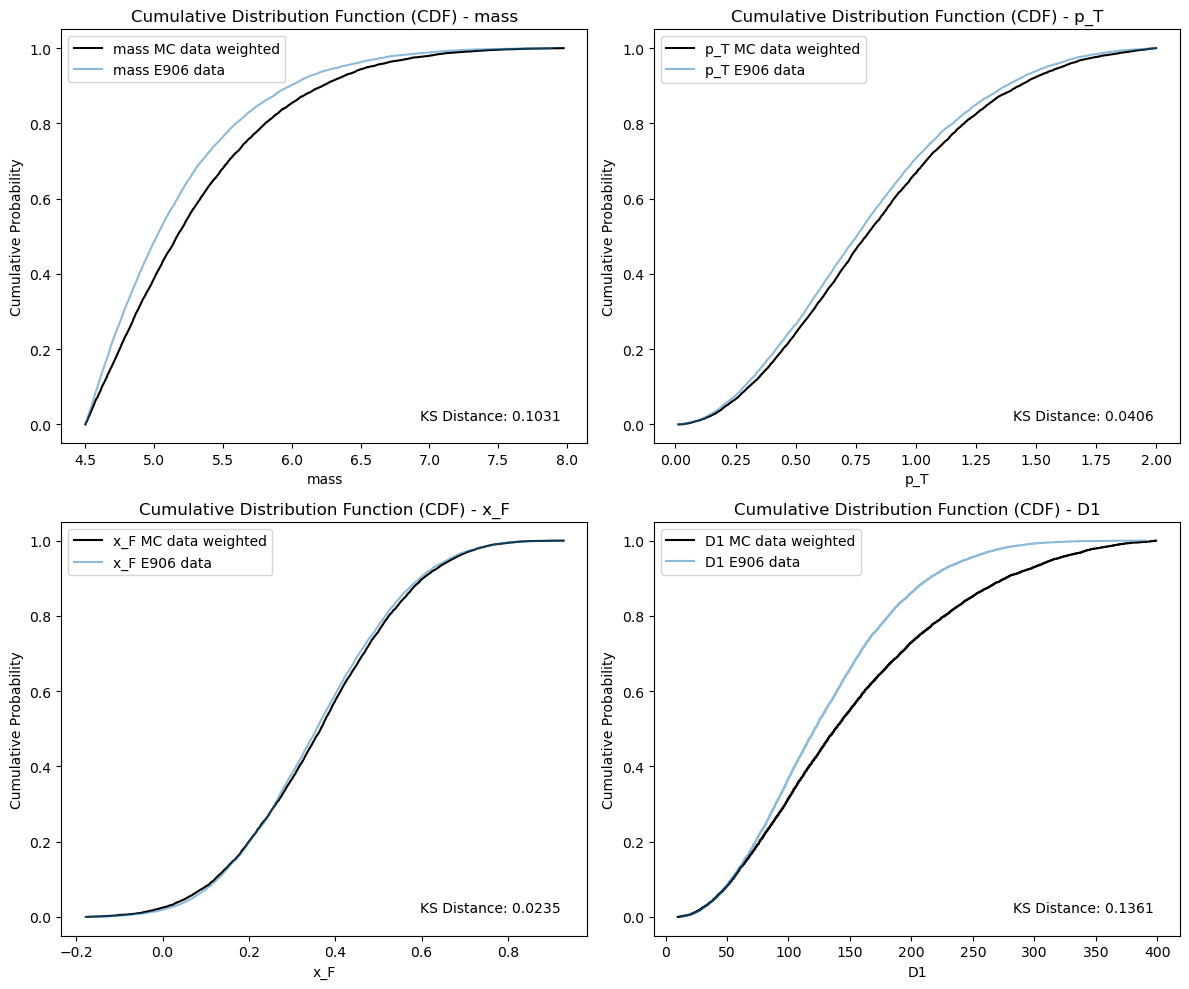

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (data0, data1, label) in enumerate([(X0_subset[:, 0], X1_subset[:, 0], 'mass'),
                                           (X0_subset[:, 1], X1_subset[:, 1], 'p_T'),
                                           (X0_subset[:, 2], X1_subset[:, 2], 'x_F'),
                                           (X0_subset[:, 3], X1_subset[:, 3], 'D1')]):

    # Calculate the CDFs
    data0_sorted = np.sort(data0)
    data1_sorted = np.sort(data1)
    data0_cdf = np.arange(len(data0_sorted)) / float(len(data0_sorted))
    data1_cdf = np.arange(len(data1_sorted)) / float(len(data1_sorted))

    # Calculate the KS statistics
    ks_distance, _ = ks_2samp(data0_sorted, data1_sorted)
    axs[i // 2, i % 2].plot(data0_sorted, data0_cdf, label=f'{label} MC data weighted', color='k')
    axs[i // 2, i % 2].plot(data1_sorted, data1_cdf, label=f'{label} E906 data', alpha=0.5)
    axs[i // 2, i % 2].set_title(f'Cumulative Distribution Function (CDF) - {label}')
    axs[i // 2, i % 2].set_xlabel(f'{label}')
    axs[i // 2, i % 2].set_ylabel('Cumulative Probability')
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].text(0.95, 0.05, f'KS Distance: {ks_distance:.4f}', ha='right', va='bottom', transform=axs[i // 2, i % 2].transAxes, fontsize=10, color='black')

plt.tight_layout()
plt.show()
